1. Import libraries

In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
from sklearn.linear_model import Ridge, Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split

2. Define functions to load data, create features

In [27]:
def create_features(df):
    df['Spread'] = df['High'] - df['Low']
    df['Gap'] = df['Open'] - df['Close'].shift(1)
    df['Intraday'] = df['Open'] - df['Close']
    return df

def drop_features(df):
    df.drop(columns=['Spread',
                     'Gap',
                     'Intraday',
                     ],
            inplace=True)

    df.drop(columns=['Open','High','Low','Close','Volume','Adj Close',
                     ], inplace=True)
    return df

def process_features(df, lookback, step):
    for i in range(step, lookback+1, step):
        df['%d Spread' % (i)] = df['Spread'].pct_change(periods=i, fill_method=None)
        df['%d Rolling Avg Spread' % (i)] = df['Spread'].rolling(window=i).mean()

        df['%d Gap' % (i)] = df['Gap'].pct_change(periods=i, fill_method=None)
        df['%d Rolling Avg Gap' % (i)] = df['Gap'].rolling(window=i).mean()

        df['%d Intraday' % (i)] = df['Intraday'].pct_change(periods=i, fill_method=None)
        df['%d Rolling Avg Intraday' % (i)] = df['Intraday'].rolling(window=i).mean()
    return df

def features(df, lookback, step):
    create_features(df)
    process_features(df, lookback, step)
    drop_features(df)
    return df

**What did we just do?**

The spread feature measures volatility. The gap feature measures the price movement after hours, considering the stock market doesn't run 24/7. The intraday feature measures the price movement from the open to close.

We will feed these features to the model to help it make a strategy.

3. Create a function to create a target.

In [28]:
def create_target(df, lookforward=2, target='Open'):
    df['Target'] = np.log(df[target].shift(periods=-lookforward)/df[target].shift(periods=-1))
    return df

**Why create a seperate target instead of using the open or close price?**

Because the price of the stock is always changing. For example, the model creates a rule to buy at 20 and sell at 30. What if the stock price goes above 30?

**But the model can see all the data, so it will know what to do if it goes to a higher price.**

What if the stock we are creating a strategy on reaches a new high, or a new low? Then the model won't know what to do. We need to scale the data in a way that doesn't make any assumptions. We will log normalize the open or close (you can pick) price and use that as our target.

4. Define the models we are going to use

We are going to use regularized linear models since they have a built in function that allows them to pick which features to keep or remove, and we are going to add a nearest neighbor model just to mix it up.

In [29]:
estimator1 = Ridge()
estimator2 = Lasso(alpha=.001)
estimator3 = KNeighborsRegressor()
models = [estimator1,estimator2,estimator3]

5. Define the parameters and the dataframe where we will store our results

Make sure that step is less than lookback. Our step is the interval of how many periods back we are going to creatures from, and lookback is how far back we will create features.

In [30]:
lookforward = 2
step = 21
lookback = 21

results = pd.DataFrame()

6. Import the data we are going to use, pick which stock we are going to use as a target, and create features from it. Then drop all NaNs and clean the data. Then split the data in half.

In [31]:
for model in models:
    if lookback >= step:
        spy = yf.download('SPY', start='2004-01-01')
        agg = yf.download('AGG', start='2004-01-01')

        spy = create_target(spy, lookforward, target='Open')

        spy = features(spy, lookback, step)
        spy = spy.add_suffix(' SPY')
        agg = features(agg, lookback, step)
        agg = agg.add_suffix(' AGG')
        cv = pd.merge(spy, agg, how='inner', on='Date')

        cv.drop(cv.tail(lookforward).index, inplace=True)
        cv.drop(cv.head(lookback).index, inplace=True)
        X = cv
        y = X[['Target SPY']]
        X = X.drop(columns=['Target SPY'])
        X.fillna(method="ffill", inplace=True)
        X.replace([np.inf, -np.inf], 0, inplace=True)
        X.fillna(0, inplace=True)

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.75, shuffle=False)

        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        results[model] = y_pred.flatten()

    else:
        print('Lookback must be greater than or equal to step')
        break

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


**What did we do here?**

When creating features for models, you want to have a lot of diverse features, one way we can do this is by creating features from different instruments. In this case, AGG is an ETF for bonds, while SPY is an ETF for stocks.

7. Visualize the correlation of the models

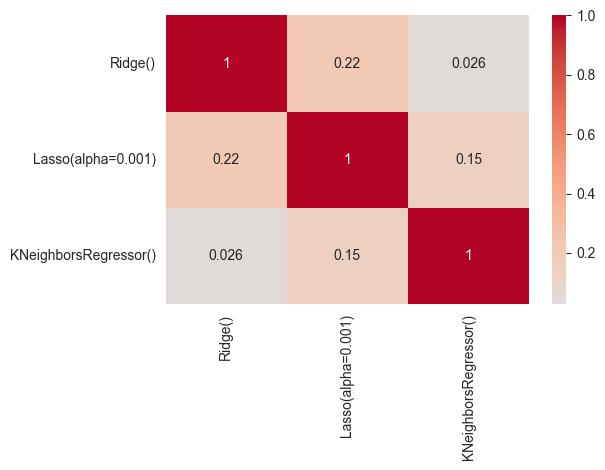

In [32]:
correlation = results.corr()
sns.heatmap(correlation, annot=True, cmap='coolwarm', center=0)
plt.tight_layout()
plt.show()

Here we see the models are mostly uncorrelated, which is good. Why do we want uncorrelated models (correlations as close to 0 as possible)? Because when we have uncorrelated models, each model has its own strategy to maximize the scoring function, and when we combine all these uncorrelated strategies, we get a meta-strategy or meta-model which has a robust strategy.

In the next notebook we will evaluate the performance of the meta-model vs different lookbacks and step intervals.